# Imports

In [47]:
%reload_ext autoreload
%autoreload 2

In [48]:
import sys
sys.path.append('/workspace/deep_birth_death/src/')

In [59]:
import pickle
import itertools
import time
import os
import statistics
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.regression import get_regression_metrics, plot_errors, plot_errors_boxplot, predicted_minus_target_vs_target, get_clipping_results

from tensorflow.keras.models import load_model

In [50]:
pd.options.display.float_format = "{:,.4f}".format

# Results generation

In [51]:
pickle_base = '/workspace/deep_birth_death/deep_learning/pickles/simulations/dataset_'
res_path = "/workspace/deep_birth_death/deep_learning/models/reg/"
n_tips = ['674', '489', '87']

data = dict()
for i in n_tips:
    with open(pickle_base + i + "_10k.pkl", 'rb') as f:
        data[i] = pickle.load(f)

In [52]:
n_trees_tested = 1000
results = dict()
inf_times = dict()

for i in n_tips:
    print('---', i, 'tips ---')
    results[i] = dict()
    inf_times[i] = dict()
    
    for label in np.unique(data[i]['div_info_test']):
        div_scenario = label.split('/')[1].split('_')[0]
        results[i][div_scenario] = dict()
        inf_times[i][div_scenario] = dict()
        
        
        #Load the model
        model_path = res_path + div_scenario + '/' + i + "_regression_"
        nn_model = load_model(model_path + 'model.keras')
        
        #Predict
        start_time = time()
        pred = nn_model.predict(np.expand_dims(data[i]['X_test'][data[i]['div_info_test'] == label], axis=2))
        ex_time = time() - start_time
        print("--- Inference time: ", div_scenario, "scenario &", ex_time, "seconds ---")  
        
        #Load the real parameter values and the rescale factor for rescaling the predictions  
        y_reg_test = data[i]['y_reg_test'][data[i]['div_info_test'] == label]
        y_reg_test = [np.array(elem) for elem in y_reg_test]
        real = y_reg_test
        
        resc_factor_test = data[i]['resc_factor_test'][data[i]['div_info_test'] == label]
            
        #Rescale the corresponding parameter values     
        if div_scenario == "BD" or div_scenario == "HE" or div_scenario == "SAT":
            
            pred[:, 0] = pred[:, 0] / resc_factor_test
        elif div_scenario == "ME":
            
            pred[:, 0] = pred[:, 0] / resc_factor_test
            pred[:, 2] = pred[:, 2] / resc_factor_test
        else:

            pred[:, 0] = pred[:, 0] / resc_factor_test
            pred[:, 1] = pred[:, 1] / resc_factor_test
            pred[:, 4] = pred[:, 4] / resc_factor_test
            
        #Clip the values 
        
        if div_scenario == "BD":
            min_value = np.array([0.01, 0.01])            
            max_value = np.array([4, 0.5])                        
            
        elif div_scenario == "HE":
            min_value = np.array([0.01, 0.8])            
            max_value = np.array([4, 0.9])   
                        
        elif div_scenario == "SAT":
            min_value = np.array([0.01])            
            max_value = np.array([4])  
  
            
        elif div_scenario == "ME":
            min_value = np.array([0.01, 0.3, 3, 0.1])            
            max_value = np.array([1, 0.8, 20, 0.3]) 
        
        elif div_scenario == "SR":
            min_value = np.array([0.25, 0.01, 0.05, 0.55, 3])            
            max_value = np.array([1.99, 1, 0.5, 0.95, 20])         
        
        else: 
            min_value = np.array([-0.2, 0.5, 1.3, 0.25, 3])            
            max_value = np.array([-0.01, 1.5, 2, 0.6, 20])   
        
        clip_pred = np.clip(pred, min_value, max_value)

        clipped_perc = (np.sum(pred != clip_pred, axis=0)/pred.shape[0])*100
        clipped_below = (np.sum(pred < min_value, axis=0) / pred.shape[0]) * 100
        clipped_above = (np.sum(pred > max_value, axis=0) / pred.shape[0]) * 100
        
        results[i][div_scenario]["clipped_perc"] = clipped_perc
        results[i][div_scenario]["clipped_above"] = clipped_above
        results[i][div_scenario]["clipped_below"] = clipped_below
                   
        #Estimate the errors         
        abs_error = abs(clip_pred-real)
        raw_error = clip_pred-real
        r_error = abs((clip_pred - real)/ real)
        
        #Save the results
        results[i][div_scenario]['raw_error'] = raw_error
        results[i][div_scenario]['abs_error'] = abs_error
        results[i][div_scenario]['real_values'] = real
        
        results[i][div_scenario]['MAE'] = np.mean(abs_error, axis=0)
        results[i][div_scenario]['MRE'] = np.mean(r_error, axis=0)
        
        inf_times[i][div_scenario] = ex_time
        

--- 674 tips ---
--- Inference time:  BD scenario & 0.2186298370361328 seconds ---
--- Inference time:  HE scenario & 0.2146437168121338 seconds ---
--- Inference time:  ME scenario & 0.21894264221191406 seconds ---
--- Inference time:  SAT scenario & 0.14229154586791992 seconds ---
--- Inference time:  SR scenario & 0.17630553245544434 seconds ---
--- Inference time:  WW scenario & 0.19204044342041016 seconds ---
--- 489 tips ---
--- Inference time:  BD scenario & 0.11290431022644043 seconds ---
--- Inference time:  HE scenario & 0.11113643646240234 seconds ---
--- Inference time:  ME scenario & 0.133836030960083 seconds ---
--- Inference time:  SAT scenario & 0.11057162284851074 seconds ---
--- Inference time:  SR scenario & 0.14476490020751953 seconds ---
--- Inference time:  WW scenario & 0.15375924110412598 seconds ---
--- 87 tips ---
--- Inference time:  BD scenario & 0.08921360969543457 seconds ---
--- Inference time:  HE scenario & 0.09650087356567383 seconds ---
--- Inference 

## Inference time

In [53]:
for i in inf_times:
    t = []
    for scenario in inf_times[i]:
        t.append(inf_times[i][scenario])
   
    print(f"\nInference time statistics for {i}:")
    print(f"Mean: {np.mean(t):.4f}")
    print(f"Standard deviation: {np.std(t):.4f}")
    print(f"Minimum: {np.min(t):.4f}")
    print(f"Maximum: {np.max(t):.4f}")


Inference time statistics for 674:
Mean: 0.1938
Standard deviation: 0.0278
Minimum: 0.1423
Maximum: 0.2189

Inference time statistics for 489:
Mean: 0.1278
Standard deviation: 0.0173
Minimum: 0.1106
Maximum: 0.1538

Inference time statistics for 87:
Mean: 0.1041
Standard deviation: 0.0156
Minimum: 0.0837
Maximum: 0.1274


## Training time

In [54]:
for i in n_tips:
    train_times = []
    
    for label in np.unique(data[i]['div_info_test']):
        div_scenario = label.split('/')[1].split('_')[0]
        
        # Load regression model 
        model_path = res_path + div_scenario + '/' + i + "_regression_"

        with open(model_path + 'model_data.pkl', 'rb') as f:
            n_params, train_time = pickle.load(f)
                
        train_times.append(train_time)
    
    print('\nTraining times for', i, 'tips')
    print('-'*5)
    print('Mean:', np.mean(train_times))
    print('Std Dev:', np.std(train_times))
    print('Max:', np.max(train_times))
    print('Min:', np.min(train_times))


Training times for 674 tips
-----
Mean: 90.99430644512177
Std Dev: 14.095962142690402
Max: 110.33470749855042
Min: 65.08766007423401

Training times for 489 tips
-----
Mean: 133.30268029371896
Std Dev: 32.791843477443926
Max: 168.56584572792053
Min: 85.2086443901062

Training times for 87 tips
-----
Mean: 118.00759176413219
Std Dev: 55.40580064564475
Max: 184.11174845695496
Min: 26.015230894088745


## Get regression metrics

In [55]:
n_tips = ['674', '489', '87']
div_scenarios = ['BD', 'HE', 'ME', 'SAT', 'SR', 'WW']

### MAE

In [56]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios: 
        print(scenario)
        data = get_regression_metrics(results, tip, scenario, 'MAE')
        print(data)

---------674---------
BD
         r      a
MAE 0.1274 0.0722
HE
         r      a
MAE 0.1875 0.0188
ME
         r      a   time   frac
MAE 0.0391 0.0673 4.8020 0.0496
SAT
     lambda 0
MAE    0.0622
SR
        r0     r1     a0     a1   time
MAE 0.0700 0.0217 0.1132 0.0961 3.5182
WW
        r0     r1     a0     a1   time
MAE 0.0361 0.1054 0.1471 0.0826 2.7317
---------489---------
BD
         r      a
MAE 0.1266 0.0736
HE
         r      a
MAE 0.2019 0.0185
ME
         r      a   time   frac
MAE 0.0384 0.0776 4.3575 0.0495
SAT
     lambda 0
MAE    0.0664
SR
        r0     r1     a0     a1   time
MAE 0.0573 0.0202 0.1011 0.0952 3.2836
WW
        r0     r1     a0     a1   time
MAE 0.0304 0.0999 0.1349 0.0863 2.7102
---------87---------
BD
         r      a
MAE 0.2291 0.1080
HE
         r      a
MAE 0.3088 0.0246
ME
         r      a   time   frac
MAE 0.0368 0.0939 5.2705 0.0483
SAT
     lambda 0
MAE    0.1640
SR
        r0     r1     a0     a1   time
MAE 0.0709 0.0204 0.1076 0.0917 2.9354

### MRE

In [57]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios: 
        print(scenario)
        data = get_regression_metrics(results, tip, scenario, 'MRE')
        print(data)

---------674---------
BD
         r      a
MRE 0.0637 0.6469
HE
         r      a
MRE 0.0999 0.0223
ME
         r      a   time   frac
MRE 0.1316 0.1383 0.6507 0.2923
SAT
     lambda 0
MRE    0.0332
SR
        r0     r1     a0     a1   time
MRE 0.1212 0.5884 0.7561 0.1324 0.5949
WW
        r0     r1     a0     a1   time
MRE 0.5454 0.1239 0.0895 0.2086 0.2595
---------489---------
BD
         r      a
MRE 0.0646 0.6519
HE
         r      a
MRE 0.1054 0.0218
ME
         r      a   time   frac
MRE 0.1315 0.1611 0.6141 0.2805
SAT
     lambda 0
MRE    0.0345
SR
        r0     r1     a0     a1   time
MRE 0.0941 0.5245 0.6399 0.1330 0.5182
WW
        r0     r1     a0     a1   time
MRE 0.4728 0.1144 0.0831 0.2222 0.2504
---------87---------
BD
         r      a
MRE 0.1182 1.0536
HE
         r      a
MRE 0.1705 0.0291
ME
         r      a   time   frac
MRE 0.1667 0.1856 0.7834 0.2729
SAT
     lambda 0
MRE    0.0873
SR
        r0     r1     a0     a1   time
MRE 0.1454 0.5651 0.6774 0.1289 0.5272

### Clipping percentage

In [62]:
for tip in n_tips:
    print(f"\n----------- Size is {tip} -----------")
    for scenario in div_scenarios:
        print(scenario)
        df_tot, df_below, df_above = get_clipping_results(results, tip, scenario)
        print(df_tot)
        print(df_below)
        print(df_above, "\n")


----------- Size is 674 -----------
BD
               a      r
Clipped % 3.7811 1.1940
             a      r
Below % 0.0000 0.3980
             a      r
Above % 3.7811 0.7960 

HE
               a      r
Clipped % 6.6465 1.1078
             a      r
Below % 0.0000 0.0000
             a      r
Above % 6.6465 1.1078 

ME
               a      r   frac   time
Clipped % 0.0000 0.0990 8.0198 0.0000
             a      r   frac   time
Below % 0.0000 0.0990 3.4653 0.0000
             a      r   frac   time
Above % 0.0000 0.0000 4.5545 0.0000 

SAT
           lambda 0
Clipped %    1.4808
         lambda 0
Below %    0.0000
         lambda 0
Above %    1.4808 

SR
              a0     a1     r0     r1   time
Clipped % 2.9928 0.0000 0.0000 0.0000 7.9463
            a0     a1     r0     r1   time
Below % 2.5800 0.0000 0.0000 0.0000 6.5015
            a0     a1     r0     r1   time
Above % 0.4128 0.0000 0.0000 0.0000 1.4448 

WW
              a0     a1     r0     r1   time
Clipped % 0.6931 1.3861

### Errors boxplots 

---------674---------
BD


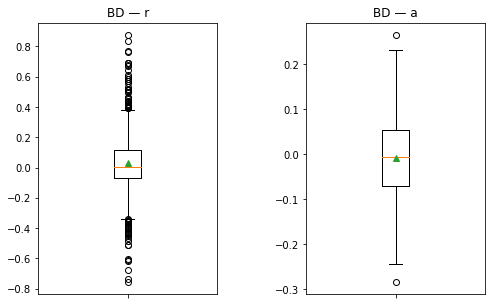

HE


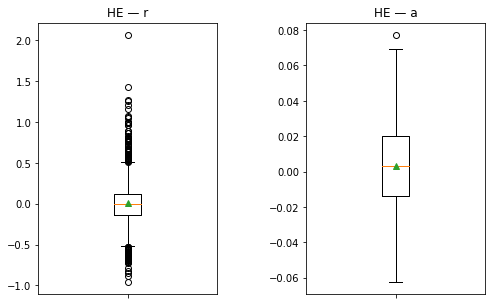

ME


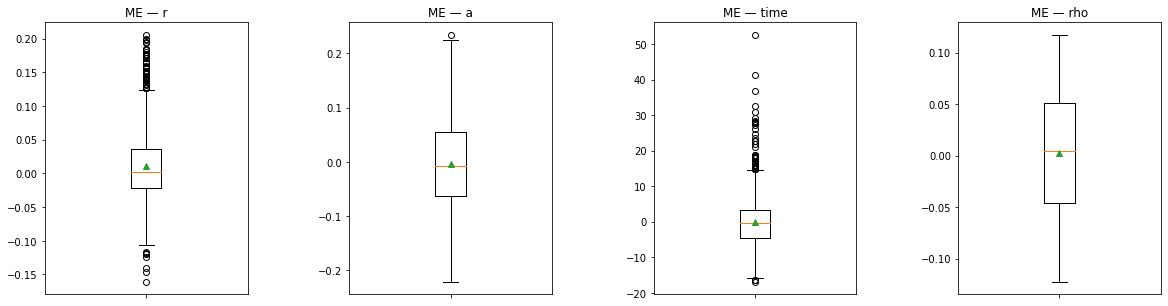

SAT


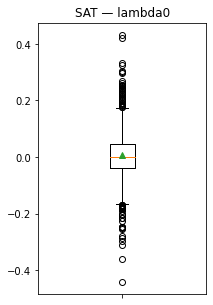

SR


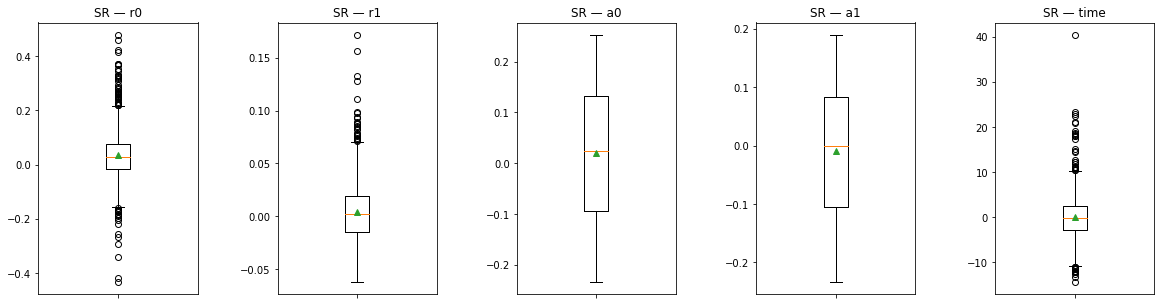

WW


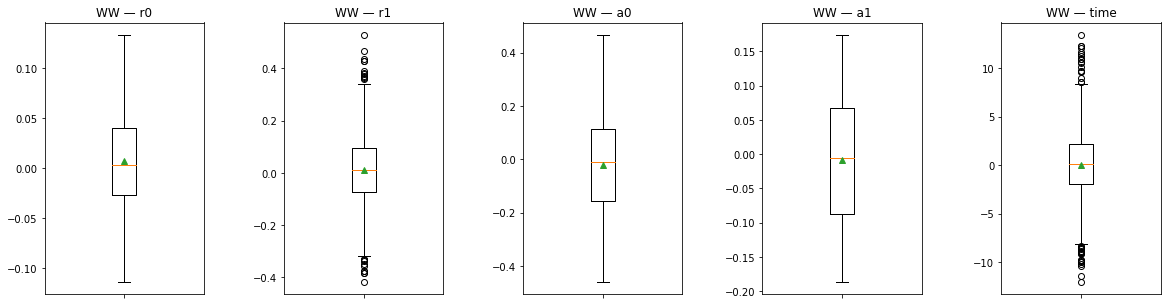

---------489---------
BD


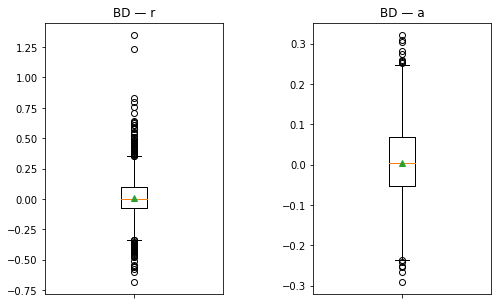

HE


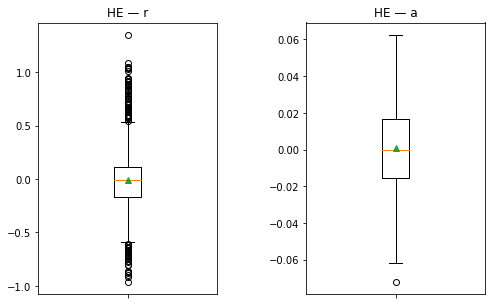

ME


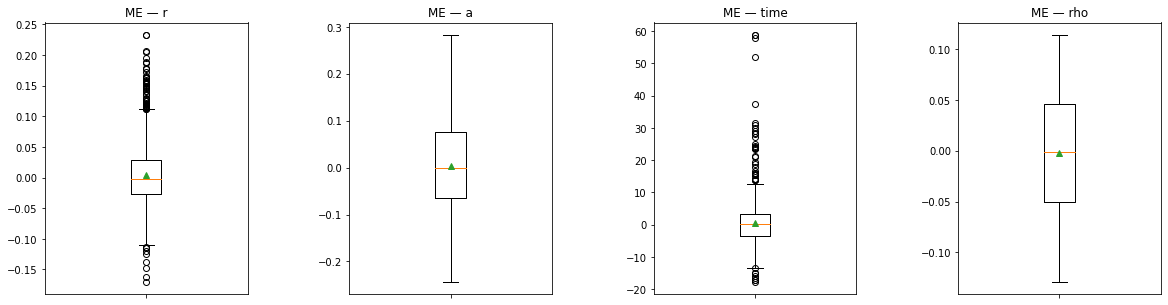

SAT


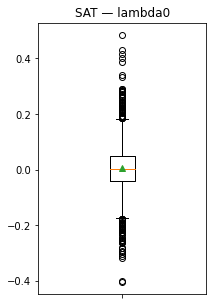

SR


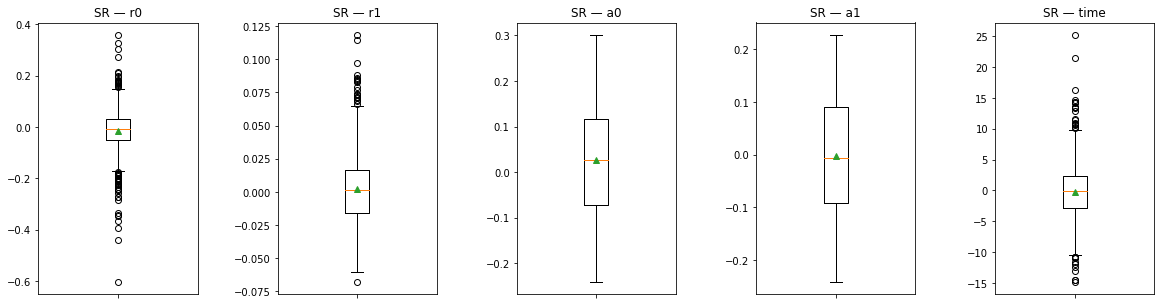

WW


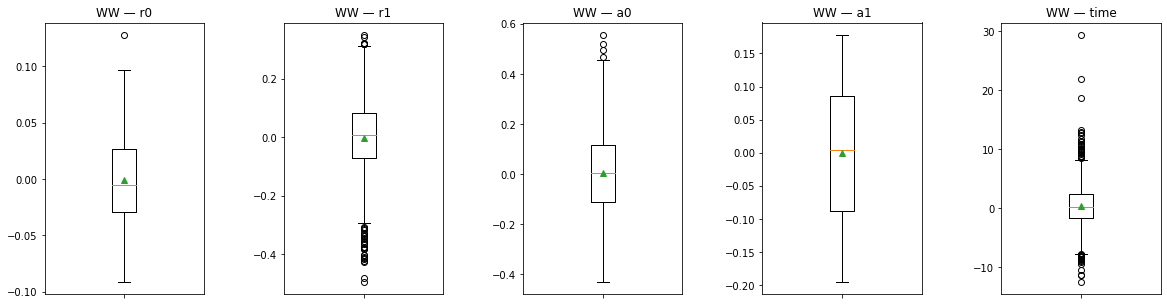

---------87---------
BD


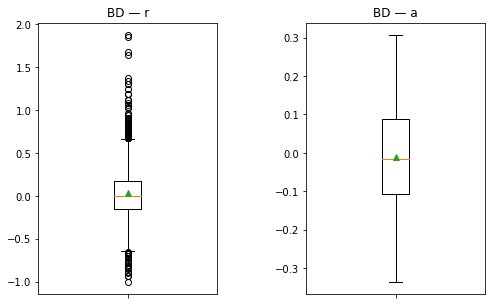

HE


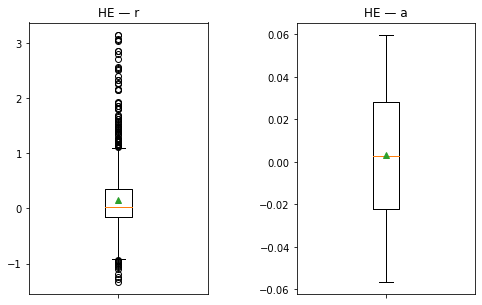

ME


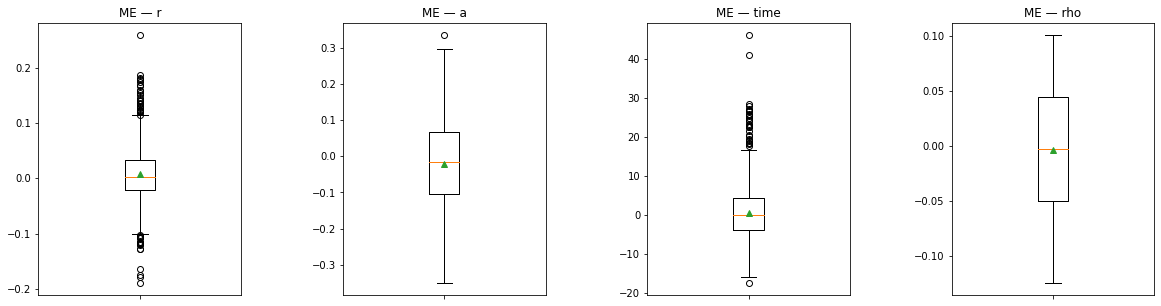

SAT


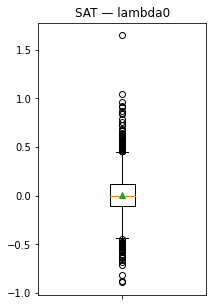

SR


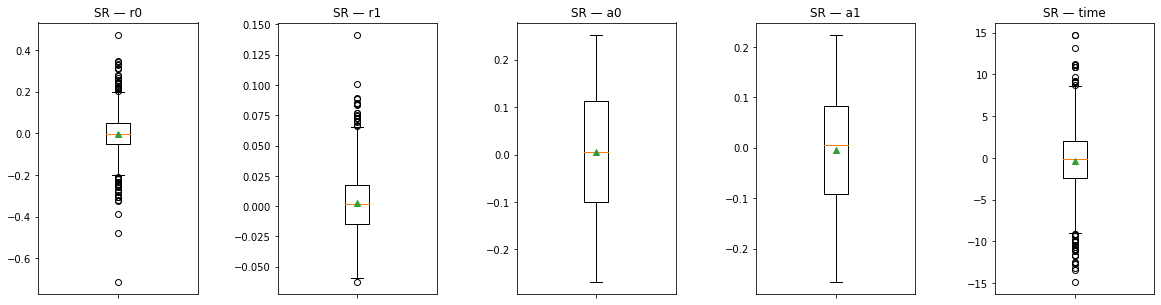

WW


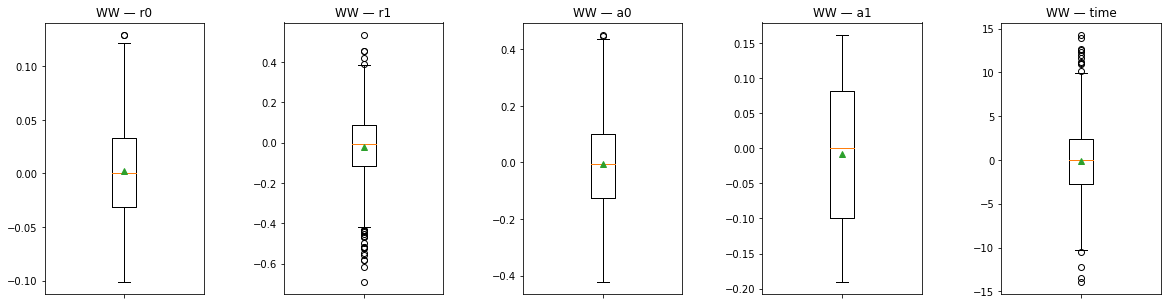

In [12]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        print(scenario)
        plot_errors_boxplot(results, tip, scenario)

### Errors swarmplots 

---------674---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


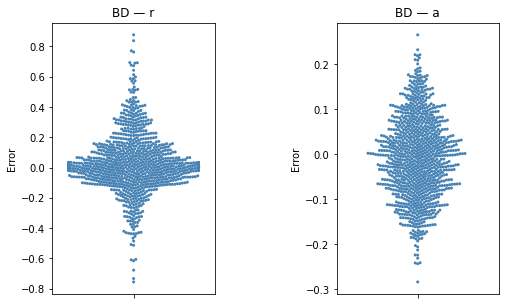

HE


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


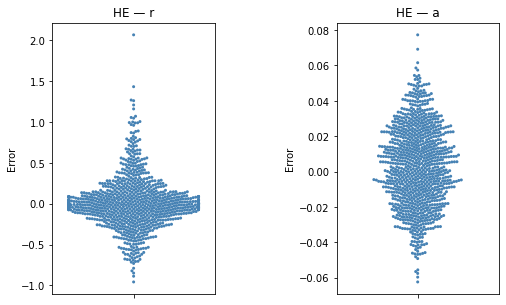

ME


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


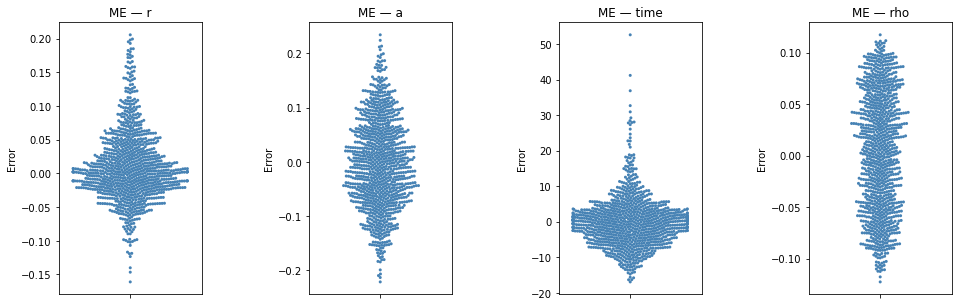

SAT


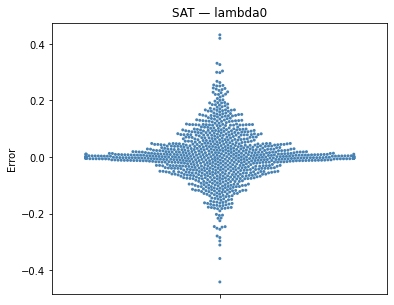

SR


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


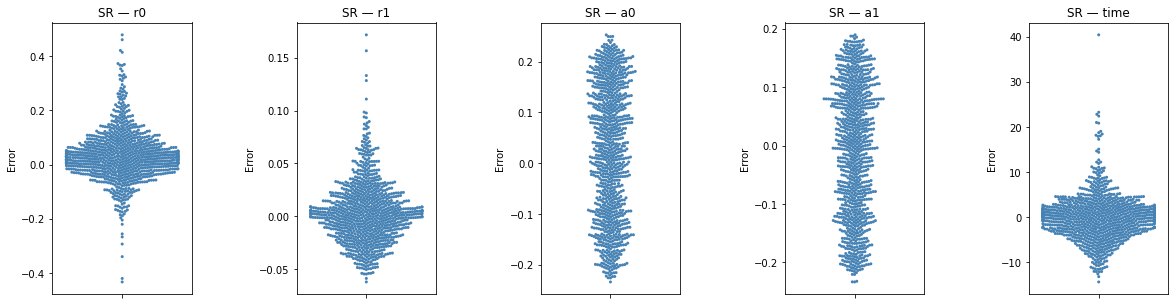

WW


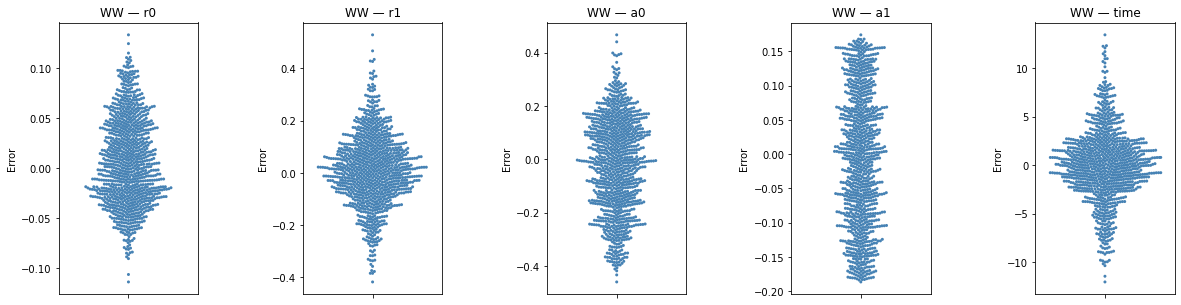

---------489---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


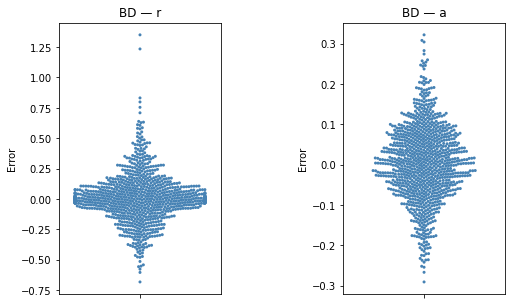

HE


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


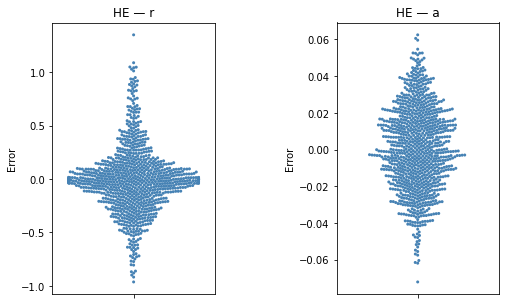

ME


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


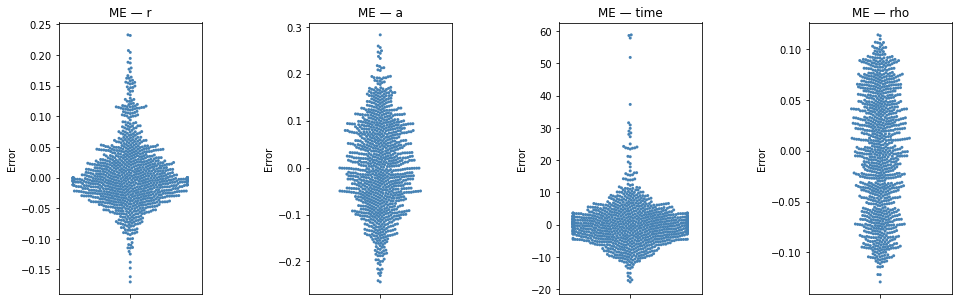

SAT


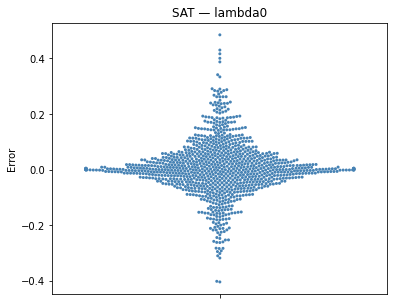

SR


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


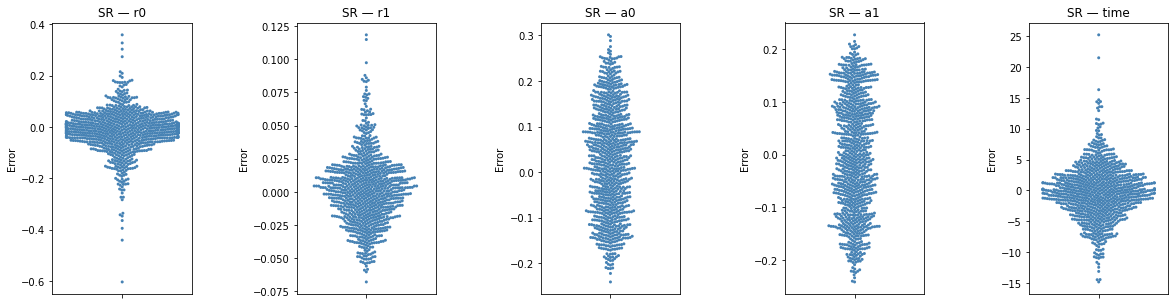

WW


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


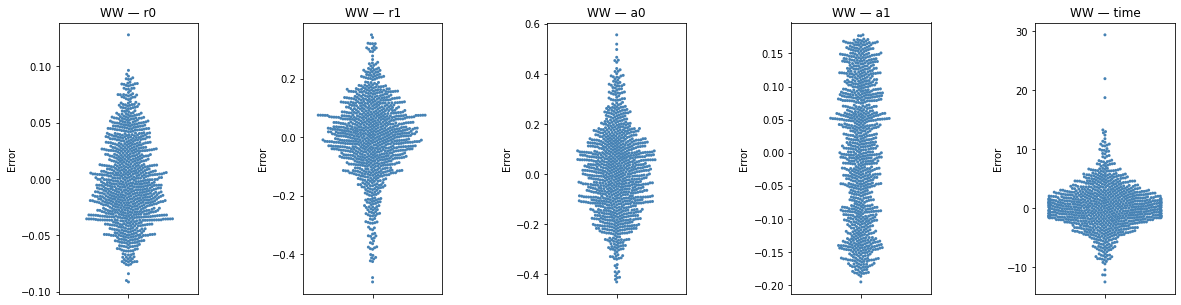

---------87---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


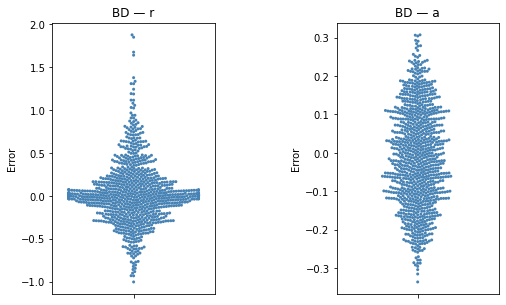

HE


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


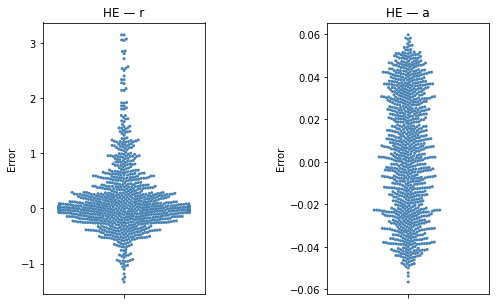

ME


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


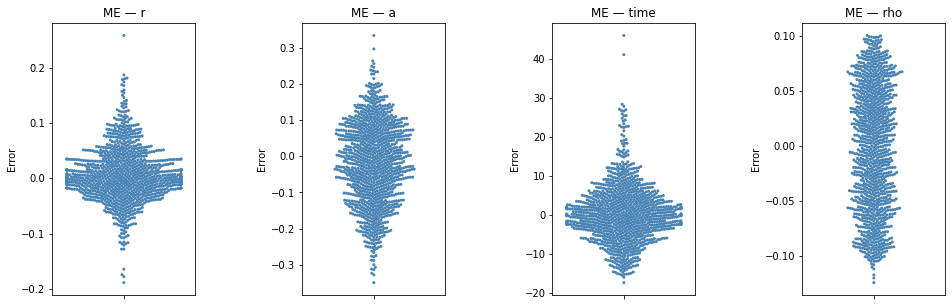

SAT


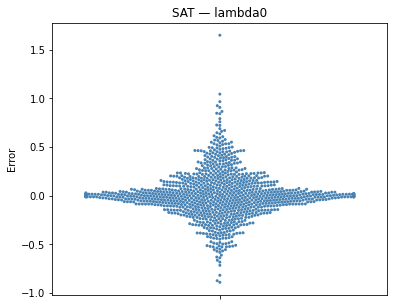

SR


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


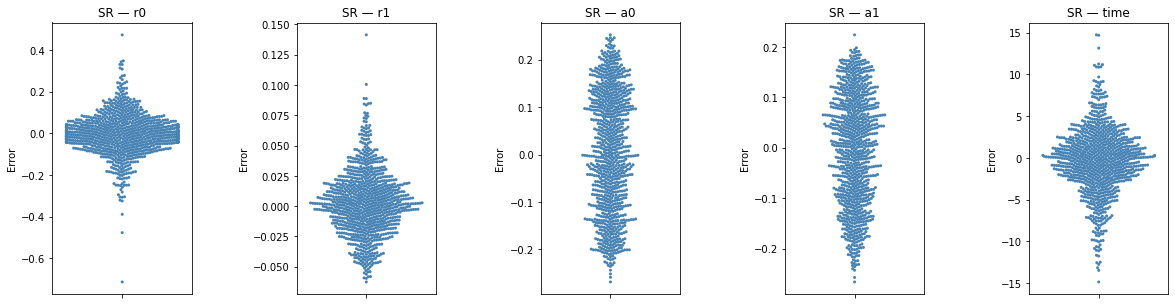

WW


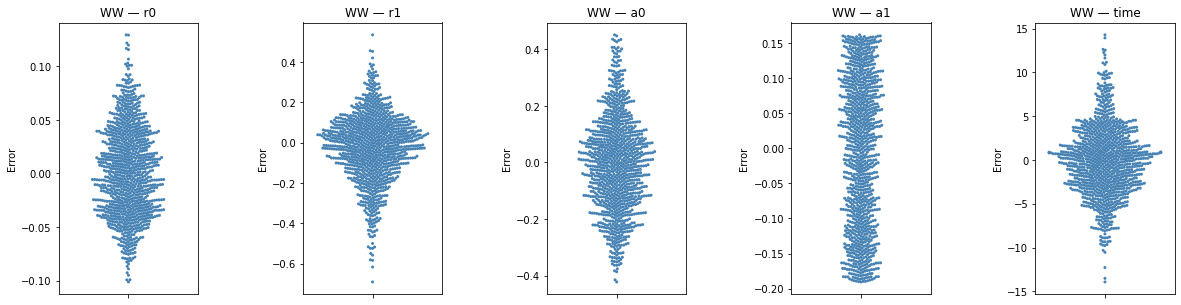

In [13]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        print(scenario)
        plot_errors(results, tip, scenario)

### Absolute errors vs target

---------674---------


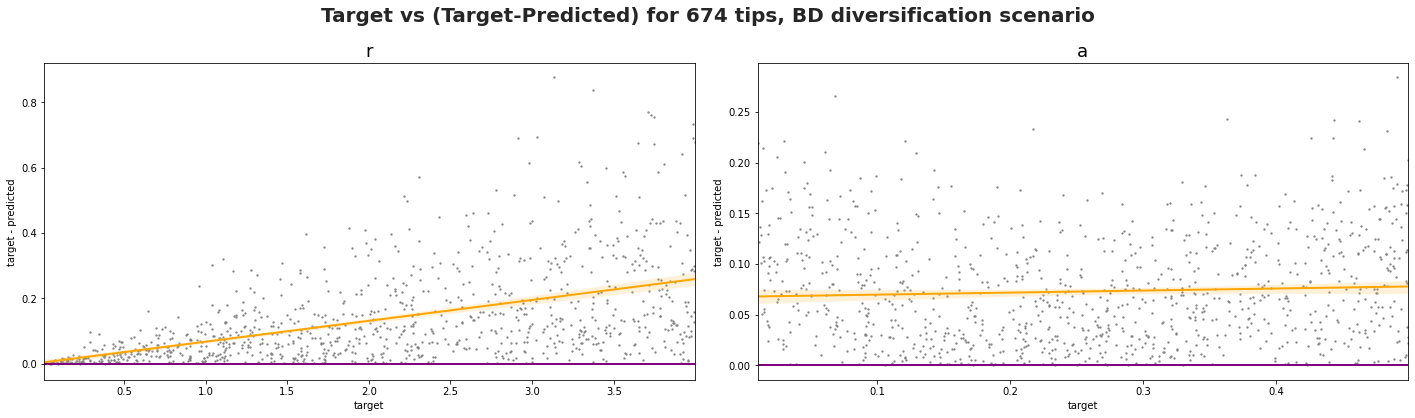

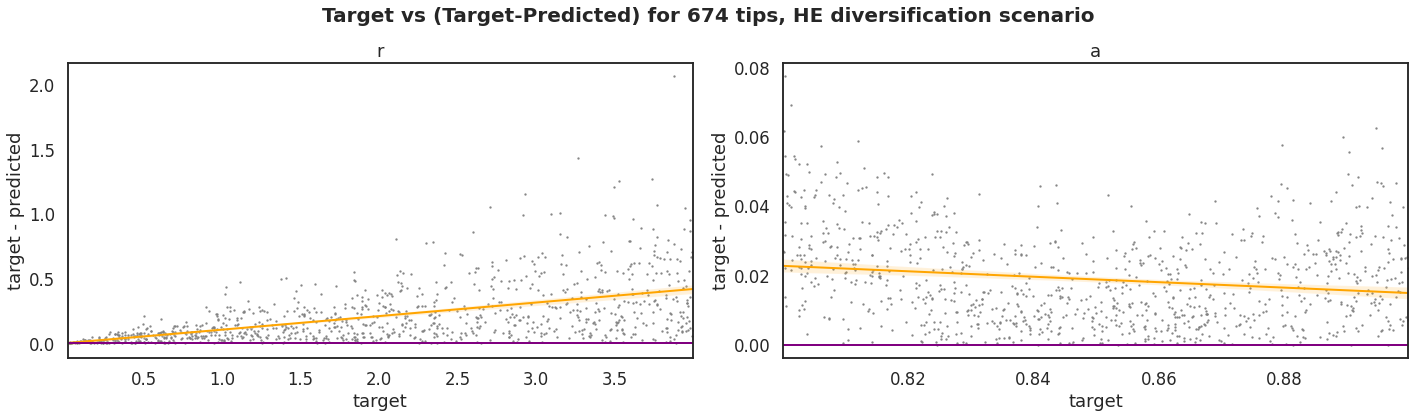

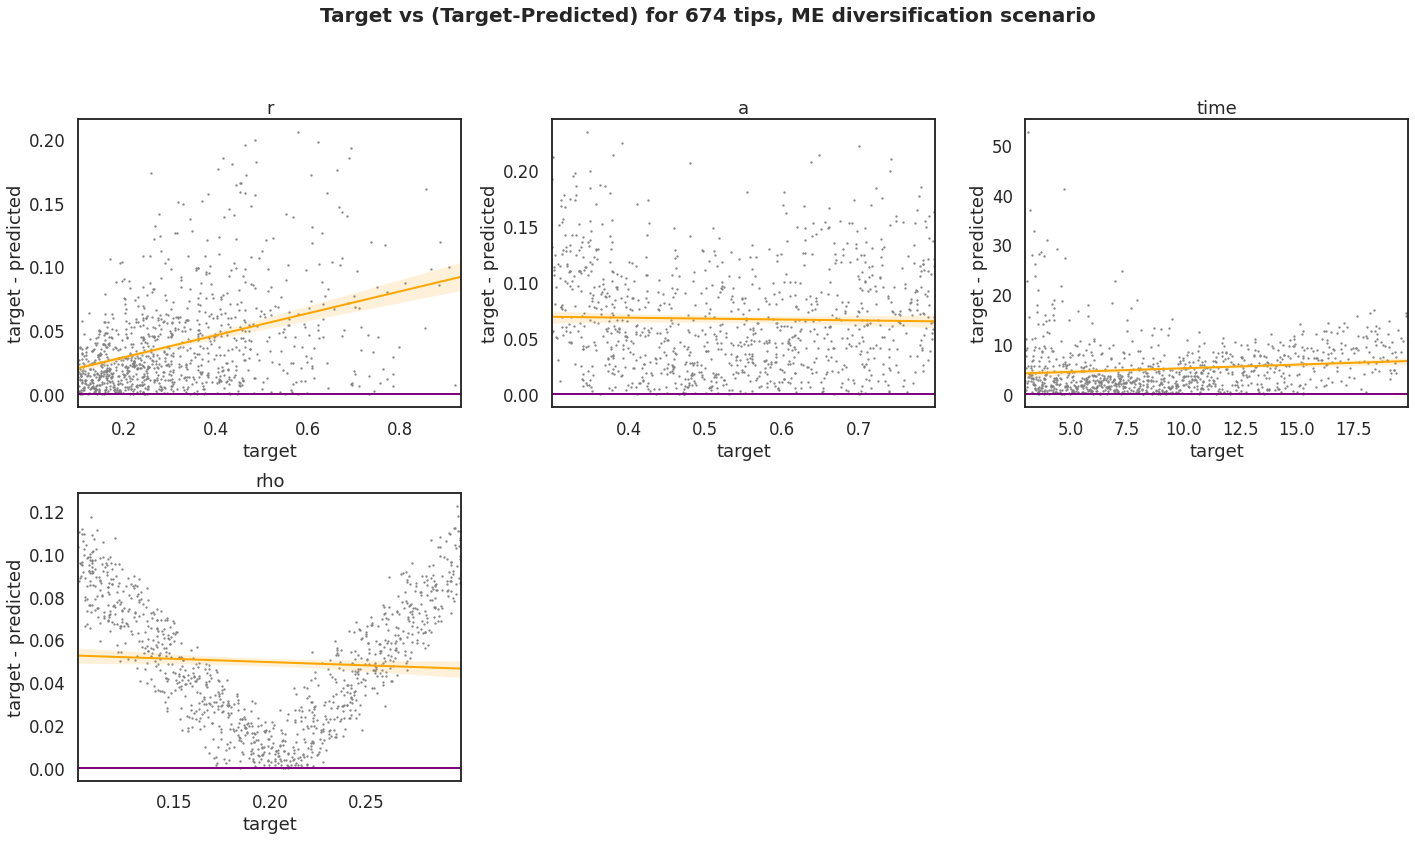

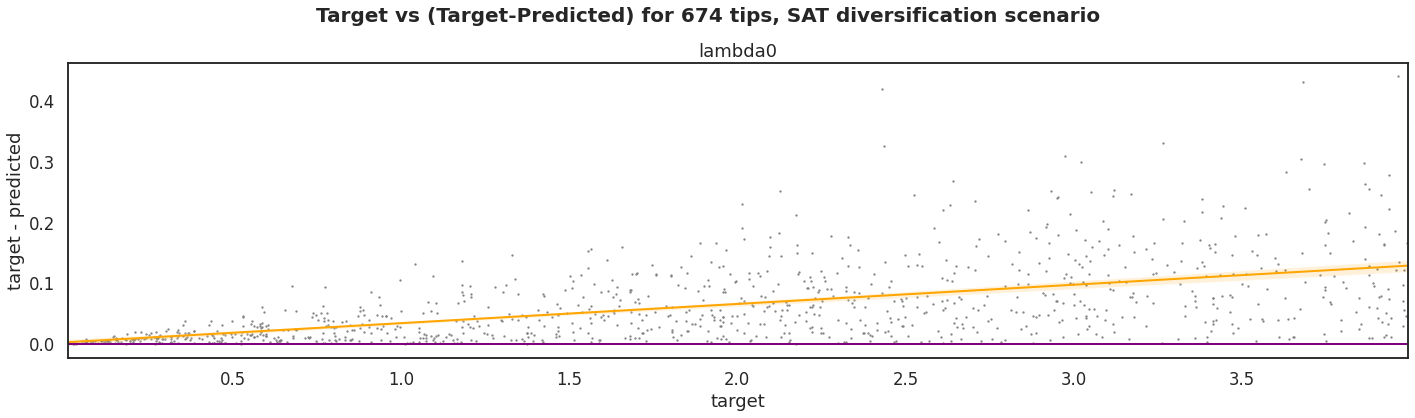

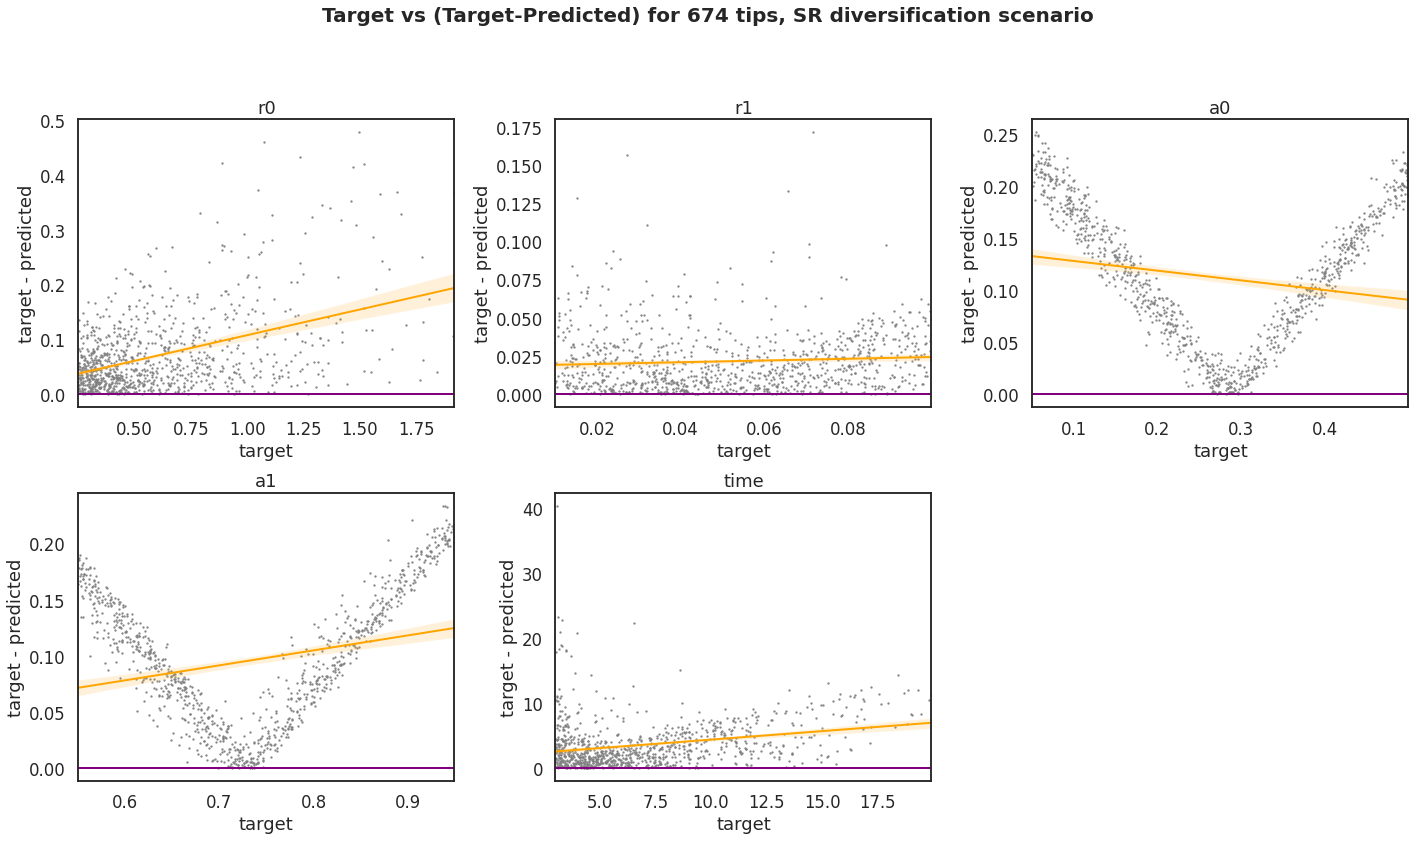

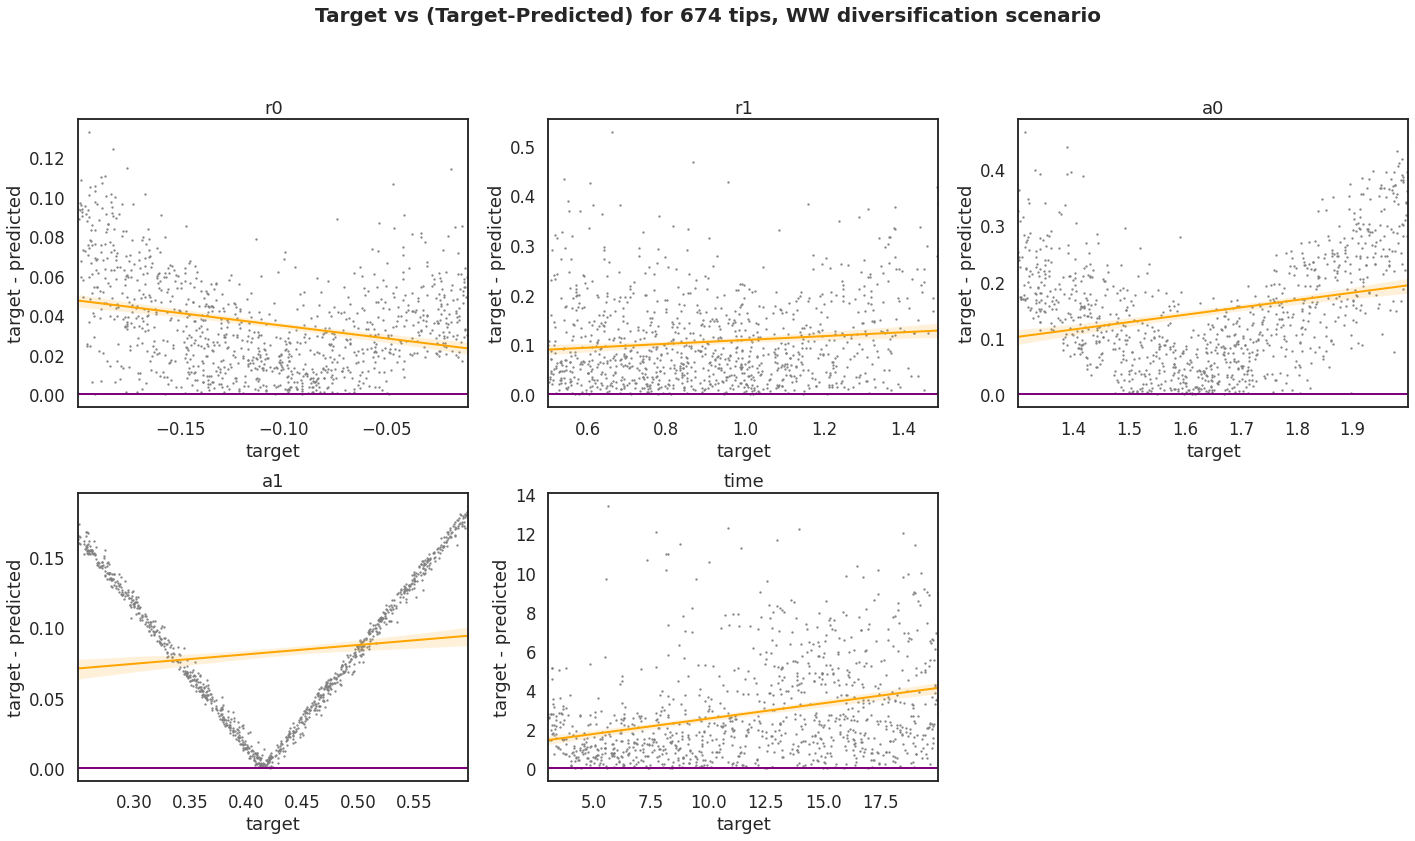

---------489---------


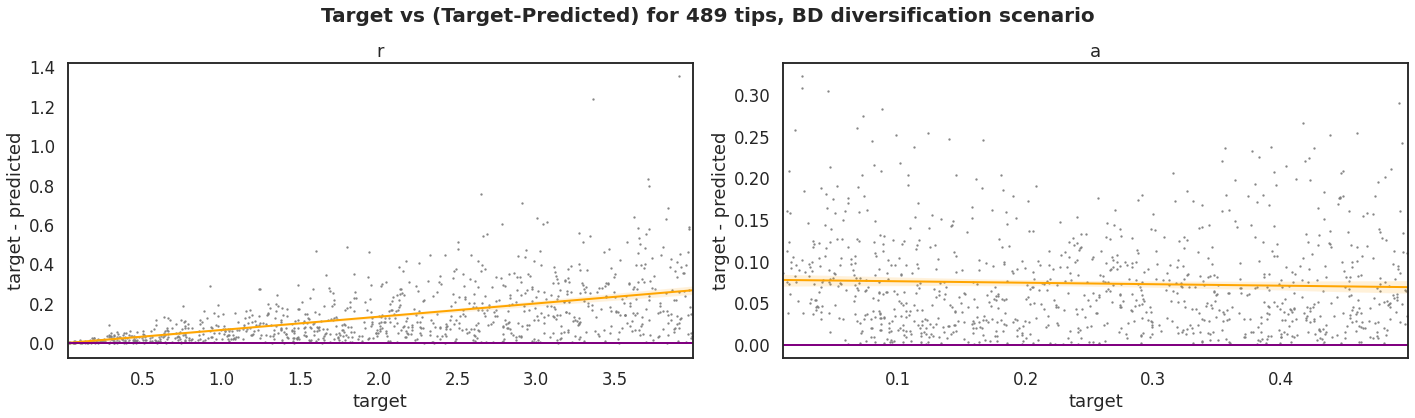

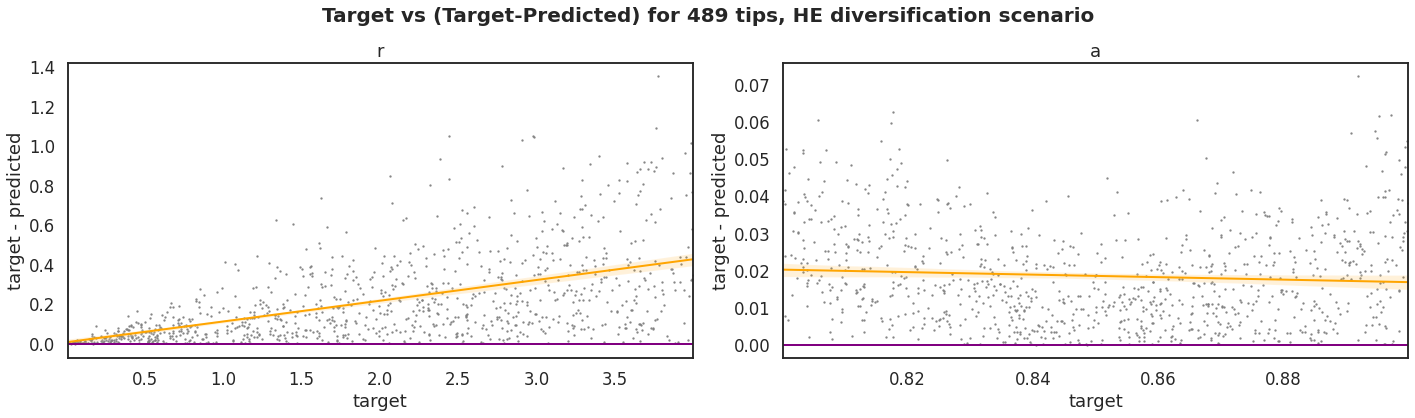

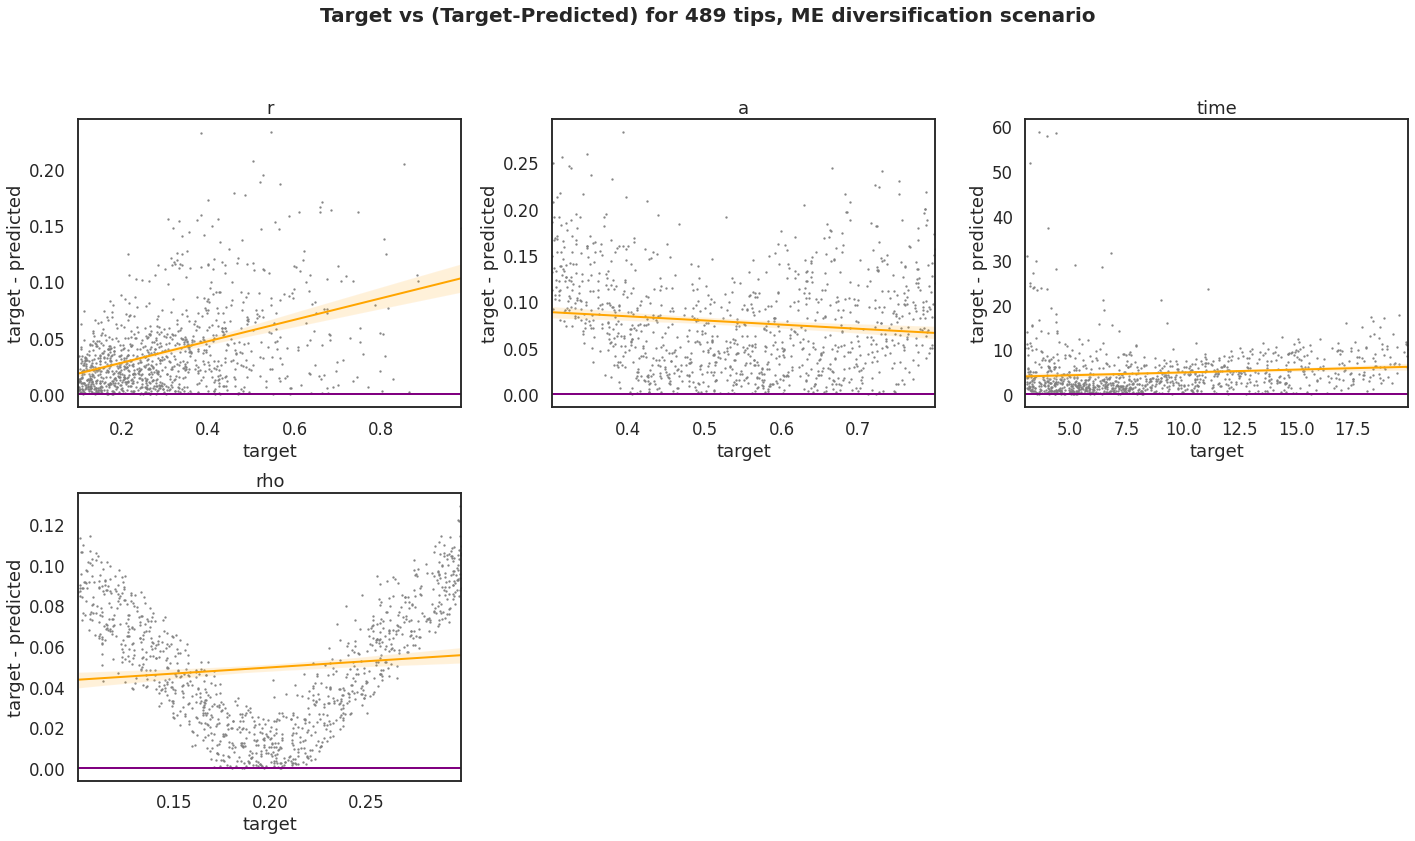

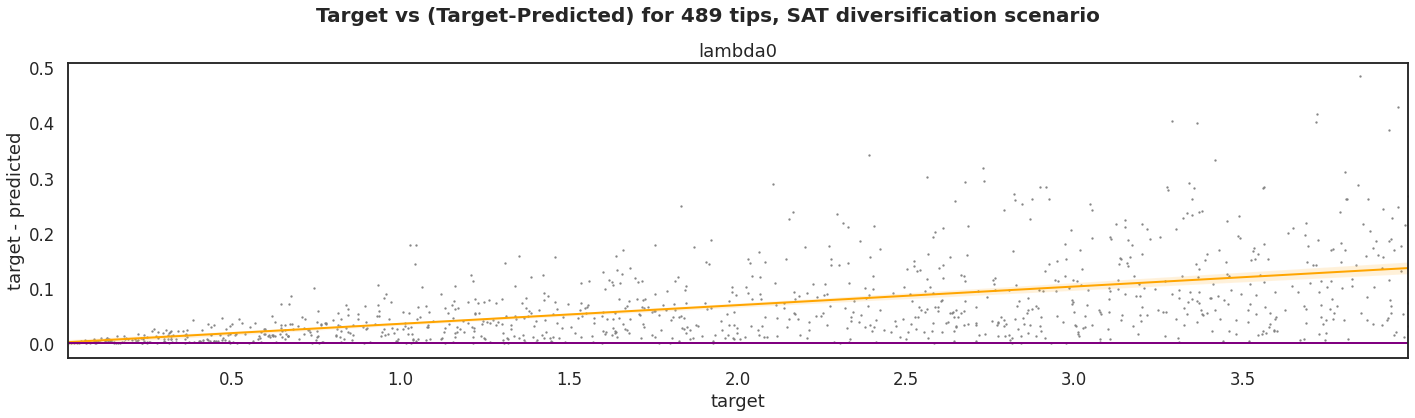

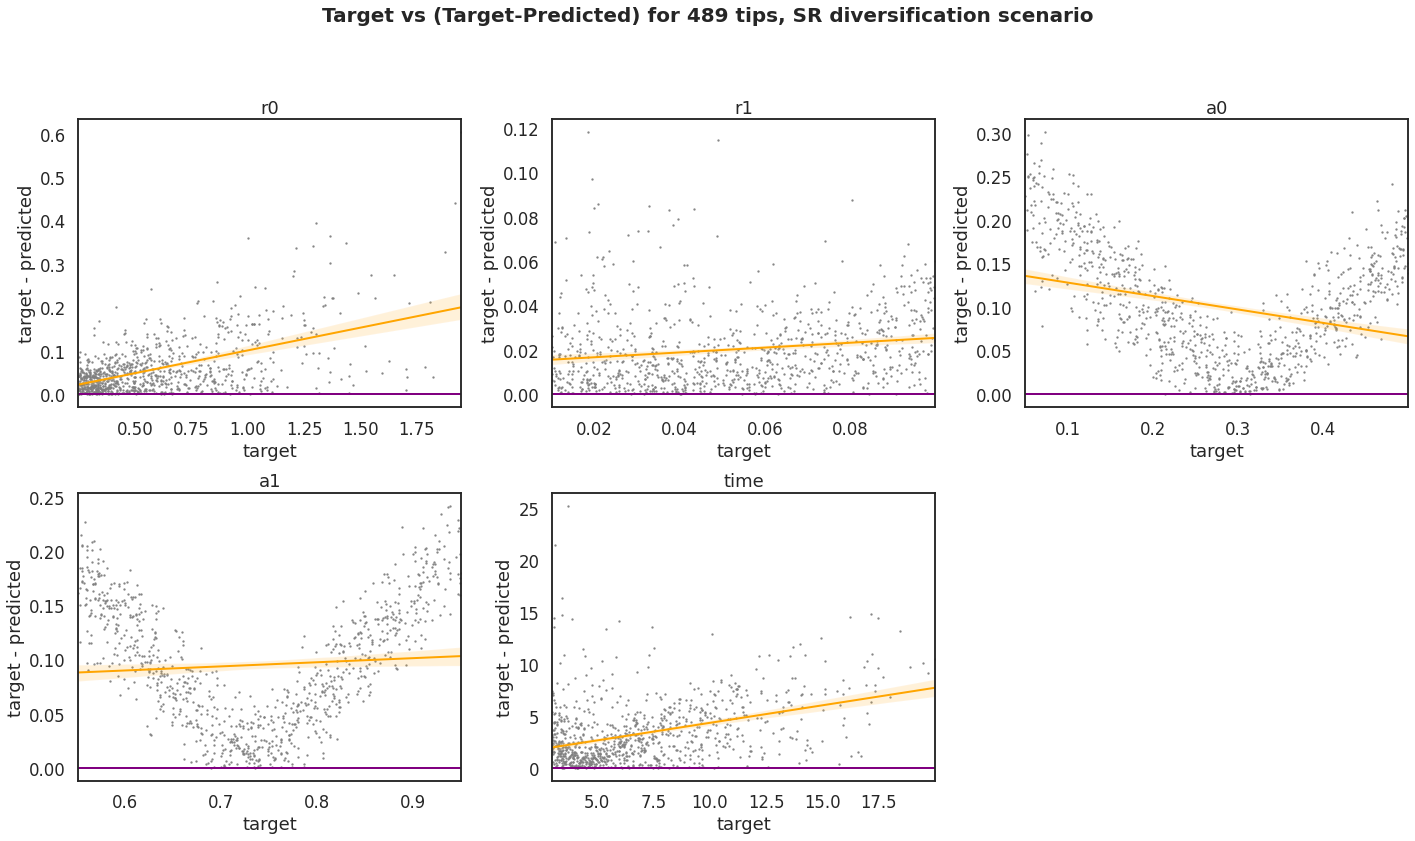

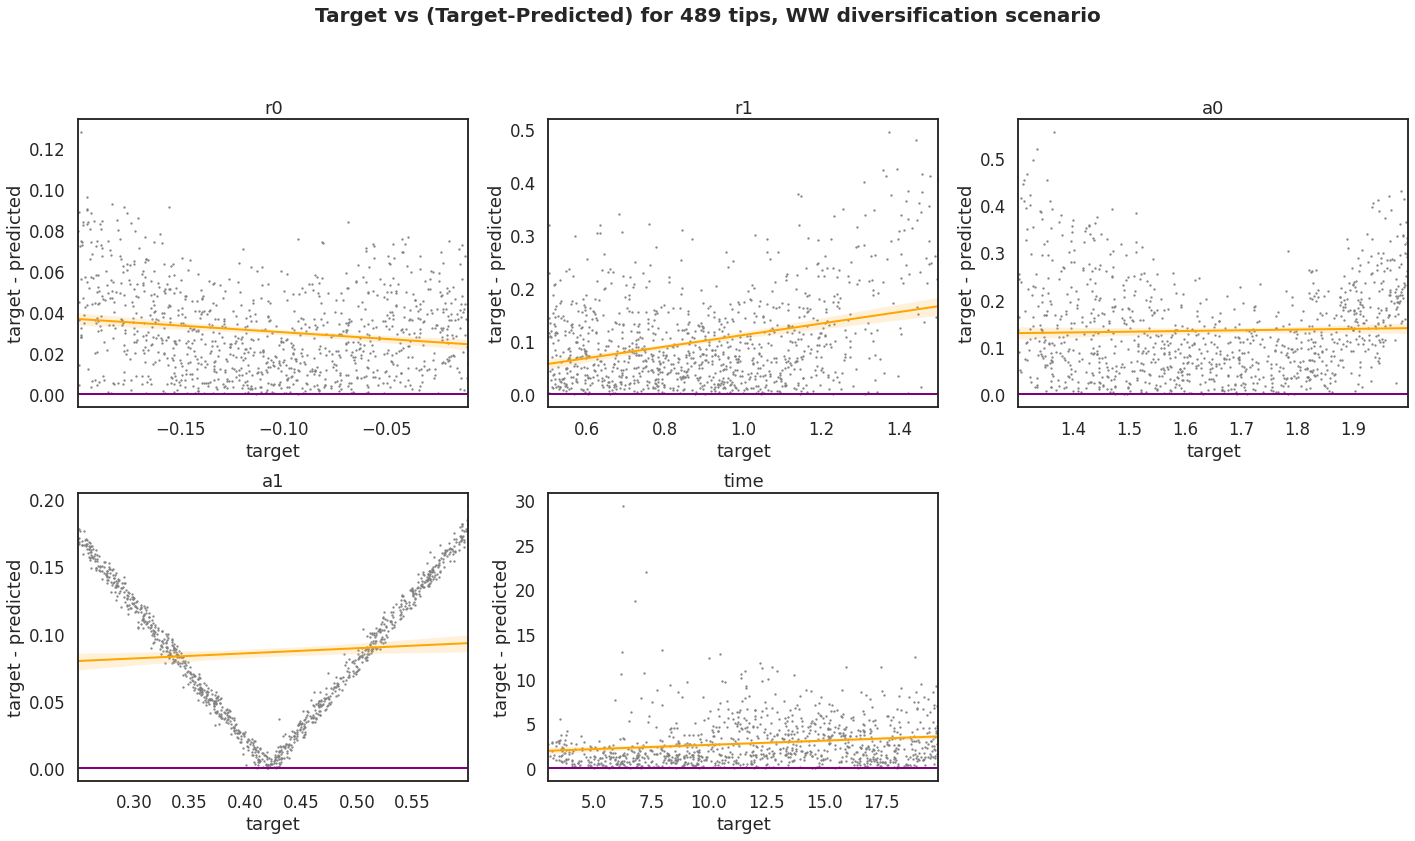

---------87---------


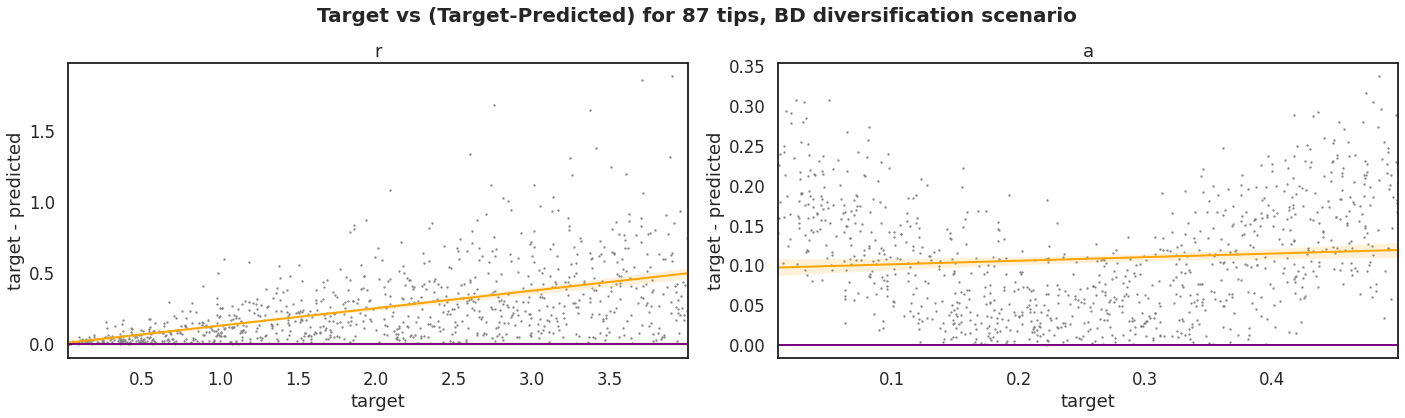

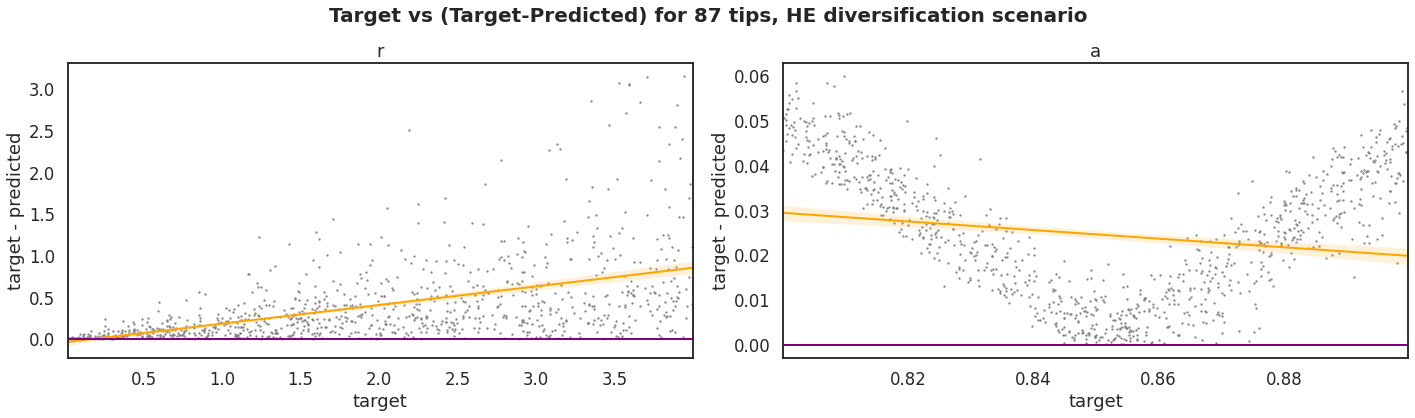

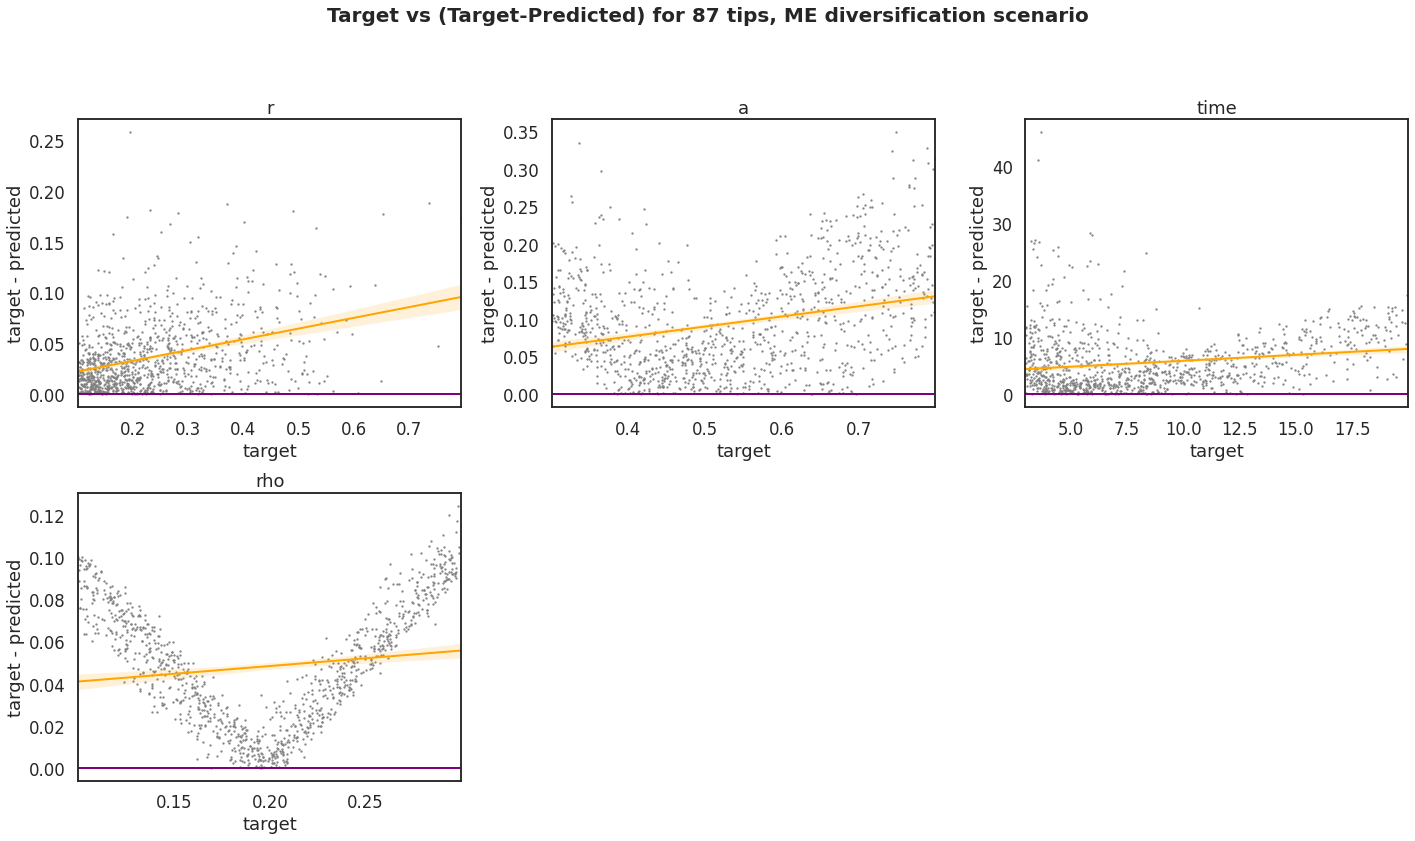

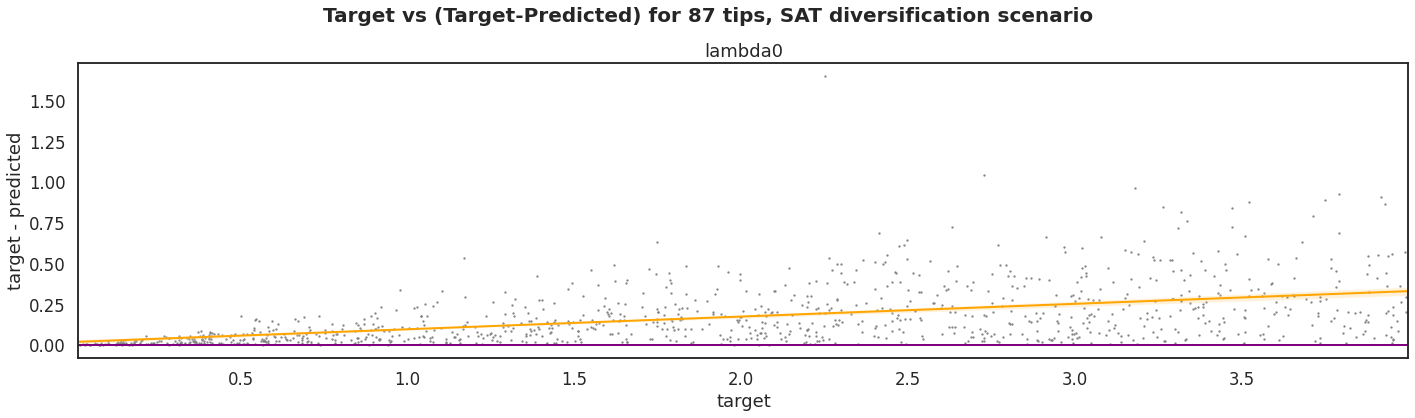

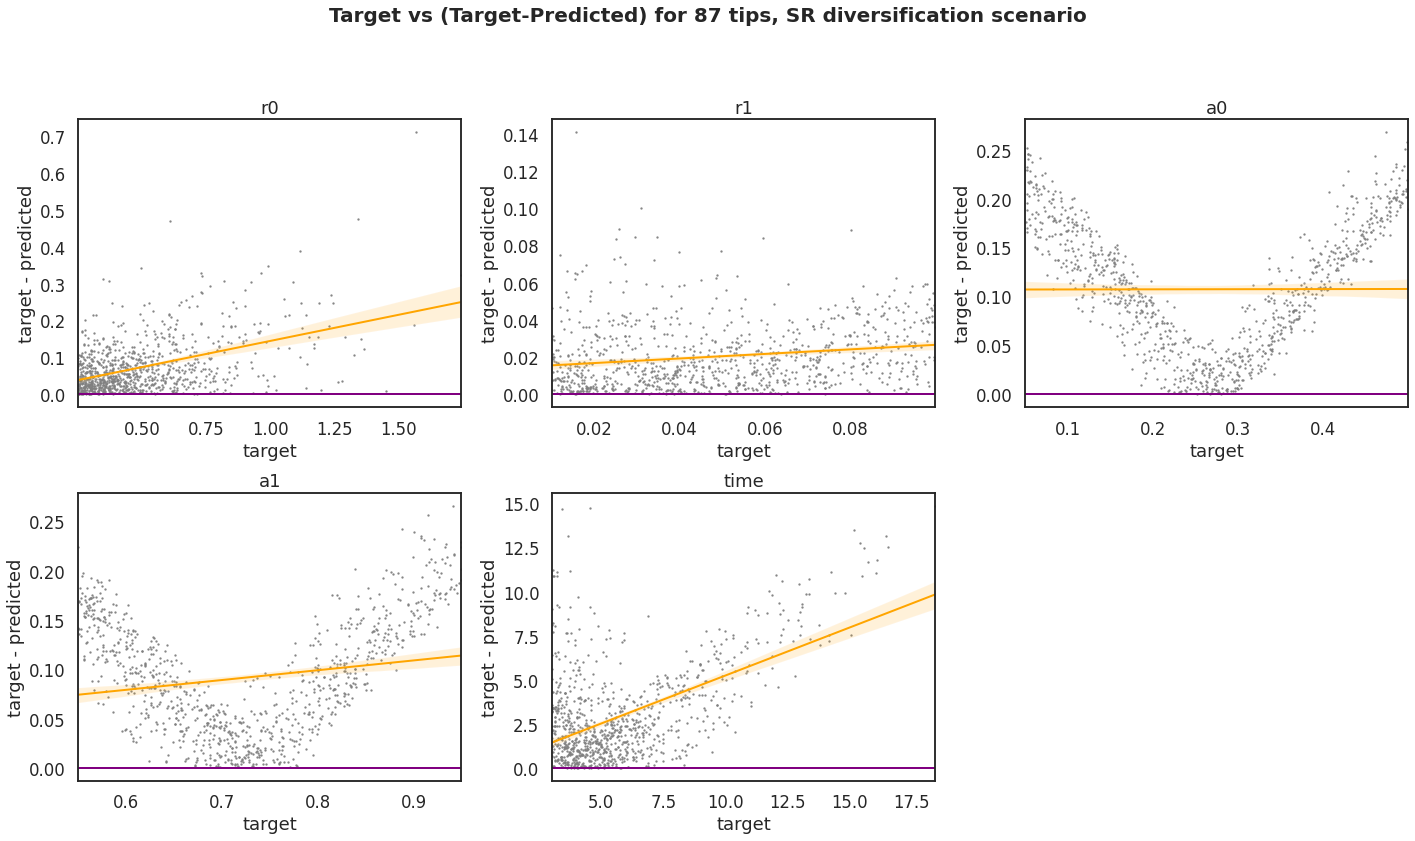

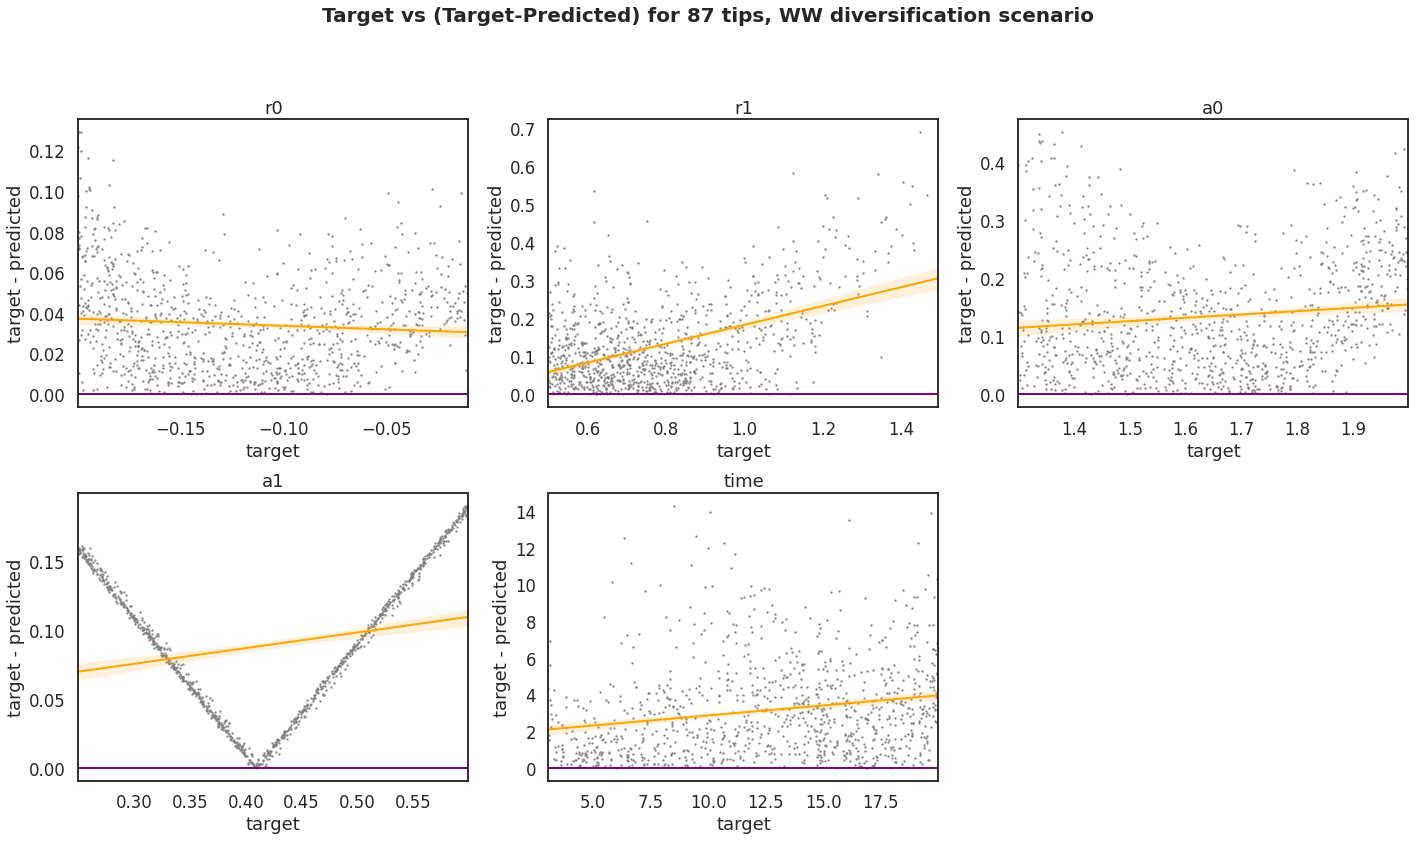

In [14]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        predicted_minus_target_vs_target(results, tip, scenario)